Advanced Regression - Assignment

#### Import Libs

In [1]:
import sys
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

In [3]:
housePrice = pd.read_csv('train.csv')

In [4]:
housePrice.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Missing Value Check

In [5]:
round(housePrice.isnull().sum()/len(housePrice.index),2)[round(housePrice.isnull().sum()/len(housePrice.index),2).values>0.15]

LotFrontage    0.18
Alley          0.94
FireplaceQu    0.47
PoolQC         1.00
Fence          0.81
MiscFeature    0.96
dtype: float64

Remove missing columns and some which may not be used like Id

In [6]:
housePrice = housePrice.drop(['Street','Utilities','Id','LotFrontage',
                              'Alley','FireplaceQu','PoolQC','Fence','MiscFeature','MoSold'],axis='columns')

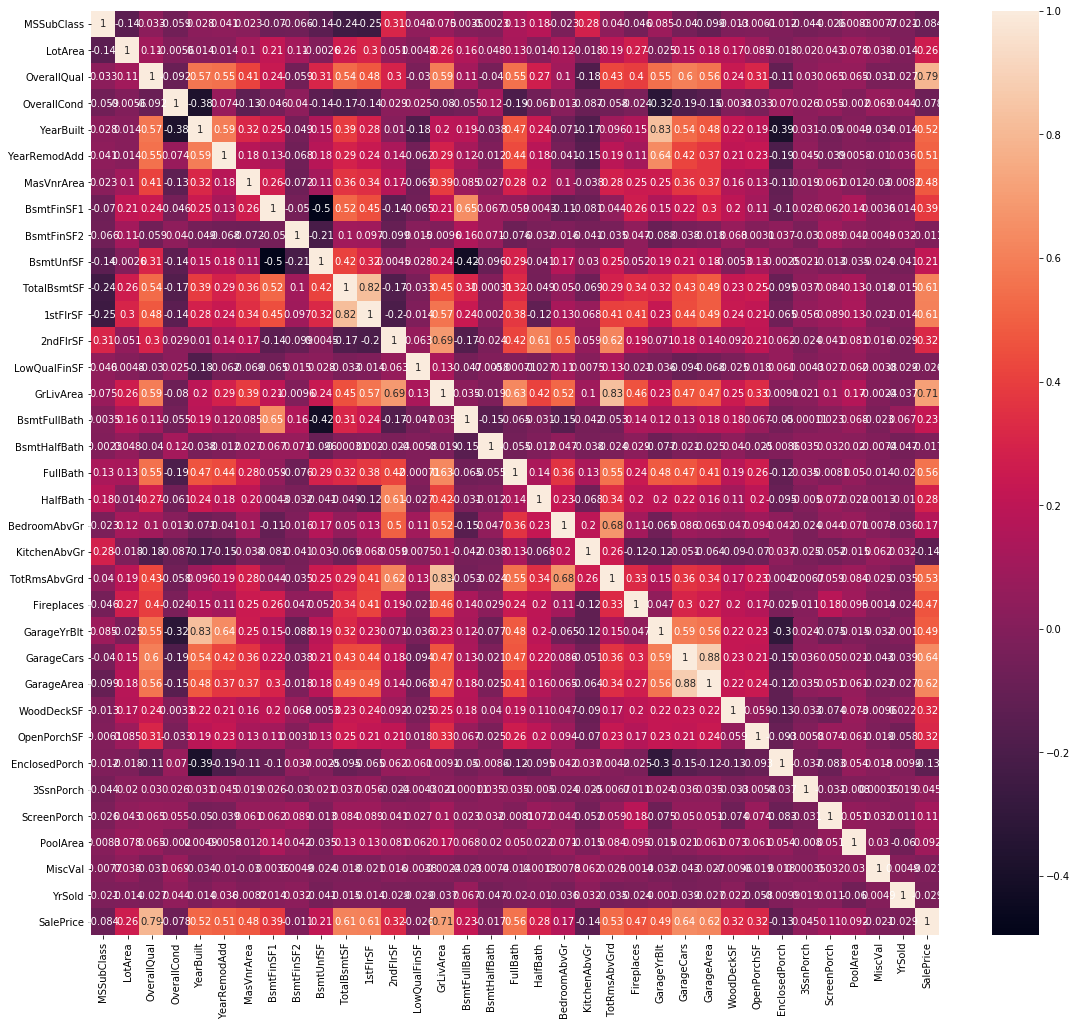

In [7]:
plt.figure(figsize=(19,17))
sns.heatmap(housePrice[list(housePrice.dtypes[housePrice.dtypes!='object'].index)].corr(),annot=True)
plt.show()

In [8]:
housePrice = housePrice.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis='columns')

In [9]:
housePrice.BsmtCond.fillna('TA',inplace=True)
housePrice.BsmtExposure.fillna('No',inplace=True)
housePrice.MasVnrType.fillna('None',inplace=True)
housePrice.MasVnrArea.fillna(housePrice.MasVnrArea.mean(),inplace=True)
housePrice.BsmtQual.fillna('TA',inplace=True)
housePrice.BsmtFinType1.fillna('Unf',inplace=True)
housePrice.BsmtFinType2.fillna('Unf',inplace=True)
housePrice.GarageType.fillna('Attchd',inplace=True)
housePrice.GarageQual.fillna('TA',inplace=True)
housePrice.GarageFinish.fillna('Unf',inplace=True)
housePrice.GarageCond.fillna('TA',inplace=True)

In [10]:
housePrice['LandSlope'] = housePrice.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
housePrice['ExterQual'] = housePrice.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housePrice['BsmtQual'] = housePrice.BsmtQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housePrice['BsmtCond'] = housePrice.BsmtCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housePrice['BsmtExposure'] = housePrice.BsmtExposure.map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
housePrice['BsmtFinType1'] = housePrice.BsmtFinType1.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
housePrice['BsmtFinType2'] = housePrice.BsmtFinType2.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
housePrice['HeatingQC'] = housePrice.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housePrice['GarageCond'] = housePrice.GarageCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housePrice['ExterCond'] = housePrice.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housePrice['LotShape'] = housePrice.LotShape.map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})
housePrice['CentralAir'] = housePrice.CentralAir.map({'N':0,'Y':1})
housePrice['KitchenQual'] = housePrice.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housePrice['GarageFinish'] = housePrice.GarageFinish.map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
housePrice['GarageQual'] = housePrice.GarageQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})


In [11]:
dummy_col = pd.get_dummies(housePrice[['SaleType','SaleCondition','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical',
        'Functional','GarageType','MSZoning','LandContour','LotConfig','PavedDrive' ]], drop_first=True)

housePrice = pd.concat([housePrice,dummy_col],axis='columns')

housePrice = housePrice.drop(['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition'],axis='columns')

In [12]:
df_train,df_test = train_test_split(housePrice,train_size=0.70,test_size=0.30,random_state=34)

In [13]:
num_col = ['MSSubClass','BsmtFinSF1','OpenPorchSF','EnclosedPorch','LotArea','OverallQual','OverallCond',
           'MasVnrArea','3SsnPorch',
           'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
           'GrLivArea','BsmtFullBath',
           'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',
           'GarageArea','WoodDeckSF','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
           'ScreenPorch','PoolArea','MiscVal','SalePrice']

scaler = StandardScaler()
df_train[num_col] = scaler.fit_transform(df_train[num_col])
df_test[num_col] = scaler.transform(df_test[num_col])

In [14]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [15]:
y_test = df_test.pop('SalePrice')
X_test = df_test

In [16]:
lm  = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,70)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=70, step=1, verbose=0)

In [17]:
rfScores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfScores.columns = ['Column_Names','Status','Rank']

In [18]:
rfeSaleCol = list(rfScores[rfScores.Status==True].Column_Names)

In [19]:
X_train = X_train[rfeSaleCol]
X_test = X_test[rfeSaleCol]

## Lasso regression 

In [20]:
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.885293452408342
0.676330967560202
